In [1]:
%load_ext autoreload
%autoreload 2

from topologylayer.nn import AlphaLayer, BarcodePolyFeature, PartialSumBarcodeLengths
from gtda.plotting import plot_point_cloud
from persim import plot_diagrams
from takenslayers import *
from videoutils import *
import matplotlib.pyplot as plt

import math

import numpy as np
from scipy.signal import convolve

import torch
from torch.autograd import Variable
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

torch.manual_seed(2)

Text(0.5, 1.0, 'Y Coordinate')

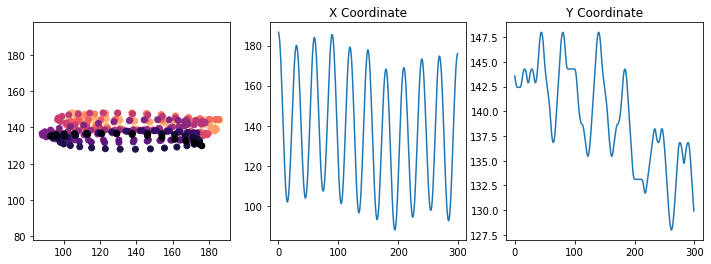

In [2]:
M = 256
N = 256
L = 15
n_frames = 300
amp = 40
n_periods = 10
noise_amp = 20
np.random.seed(0)
frames, X = simulate_moving_blob(M, N, L, n_frames, amp, n_periods, noise_amp)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=np.arange(n_frames), cmap='magma_r')
plt.axis("equal")
plt.subplot(132)
plt.plot(X[:, 0])
plt.title("X Coordinate")
plt.subplot(133)
plt.plot(X[:, 1])
plt.title("Y Coordinate")

In [3]:
save_video("blob.avi", frames, 30)

Text(0.5, 1.0, 'Y Coordinate')

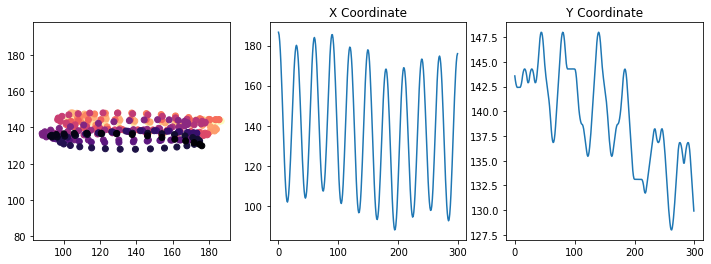

In [4]:
frames = np.array(frames, dtype=float)/255
X = get_blob_cm(frames)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=np.arange(n_frames), cmap='magma_r')
plt.axis("equal")
plt.subplot(132)
plt.plot(X[:, 0])
plt.title("X Coordinate")
plt.subplot(133)
plt.plot(X[:, 1])
plt.title("Y Coordinate")

In [5]:
X = frames[:, :, 0, :]
X = np.moveaxis(X, [0, 1, 2], [1, 2, 0])
X = X[:, None, :, :]
print(X.shape)

(300, 1, 256, 256)


In [6]:
class AutoencoderCNN(nn.Module):
    def __init__(self, imgres, depth, dim=10):
        """
        Parameters
        ----------
        imgres: int
            Resolution of the video frames to be applied
        depth: int
            Depth of the CNN
        dim: int
            Dimension of the latent space
        """
        super(AutoencoderCNN, self).__init__()
        self.imgres = imgres
        self.depth = depth
        self.dim = dim
        
        ## Step 1: Create Convolutional Down Network
        self.convdown = []
        lastchannels = 1
        channels = 32
        for i in range(depth):
            self.convdown.append(nn.Conv2d(lastchannels, channels, 3, stride=2, padding=1))
            self.convdown.append(nn.ReLU())
            lastchannels = channels
        flatten = nn.Flatten()
        res_down = int(imgres/(2**depth))
        flatten_dim = channels*res_down**2
        latentdown = nn.Linear(flatten_dim, dim)
        latentdown_relu = nn.ReLU()
        self.convdown += [flatten, latentdown, latentdown_relu]
        
        ## Step 2: Create Convolutional up layer
        latentup = nn.Linear(dim, flatten_dim)
        latentup_relu = nn.ReLU()
        reshape = nn.Unflatten(1, (channels, res_down, res_down))
        self.convup = [latentup, latentup_relu, reshape]
        for i in range(depth):
            nextchannels = channels//2
            if i == depth-1:
                nextchannels = 1
            self.convup.append(nn.ConvTranspose2d(channels, nextchannels, 3, stride=2, padding=1, output_padding=1))
            channels = channels//2
            self.convup.append(nn.ReLU())
    
    def forward(self, x):
        layers = self.convdown + self.convup
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
    def project_latent(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu, self.conv3, self.conv3_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
model = AutoencoderCNN(imgres=X.shape[-1], depth=5, dim=10)
data = torch.from_numpy(X).float()
print(data.shape)
res = model(data)
print(res.shape)

data = np.array(res.detach().numpy())
print("np.sum(data) = {}\nnp.max(data) = {}\nnp.min(data) = {}".format(np.sum(data), np.max(data), np.min(data)))
data = np.array(255*data, dtype=np.uint8)
print("np.sum(data) = ", np.sum(data))

data = np.moveaxis(data, (0, 1, 2, 3), (3, 2, 0, 1))

save_video("initial.avi", data, 30)

torch.Size([300, 1, 256, 256])
torch.Size([300, 1, 256, 256])
np.sum(data) = 0.0
np.max(data) = 0.0
np.min(data) = 0.0
np.sum(data) =  0
(256, 256, 3, 300)
